# Linear Regression Implementation from Scratch

Now we are going to implement some machine learning / deep learning algorithms by PyTorch

The easiest is linear regression.

In this notebook, **We will implement the entire method from scratch,
including the data pipeline, the model,
the loss function, and the minibatch stochastic gradient descent optimizer.**

In this section, we will rely only on tensors and auto differentiation.
Afterwards, we will introduce a more concise implementation.


In [29]:
%matplotlib inline
import random
import torch
import numpy as np
from d2l import torch as d2l

## Generating the Dataset

To keep things simple, we will **construct an artificial dataset
according to a linear model with additive noise.**

We generate a dataset containing 1000 examples, each consisting of 2 features
sampled from a standard normal distribution.
Thus our synthetic dataset will be a matrix $\mathbf{X}\in \mathbb{R}^{1000 \times 2}$.

**The true parameters generating our dataset will be
$\mathbf{w} = [2, -3.4]^\top$ and $b = 4.2$,
and** our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:
**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**

In [30]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [31]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that [**each row in `features` consists of a 2-dimensional data example
and that each row in `labels` consists of a 1-dimensional label value (a scalar).**]


In [26]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([-0.7515, -0.1366]) 
label: tensor([3.1674])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.


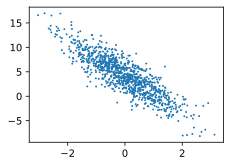

In [32]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## Reading the Dataset

Recall that training models consists of making multiple passes over the dataset,
grabbing one minibatch of examples at a time, and using them to update our model.
So we are going to define a utility function
to shuffle the dataset and access it in minibatches.

The `data_iter` function **takes a batch size, a matrix of features,
and a vector of labels, yielding minibatches of the size `batch_size`.**
Each minibatch consists of a tuple of features and labels.


In [28]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each minibatch tells us
both the minibatch size and the number of input features.
Likewise, our minibatch of labels will have a shape given by `batch_size`.

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.6351,  1.3357],
        [-0.7714,  0.6398],
        [-1.9176, -0.6603],
        [-1.0405,  0.2783],
        [-1.0440,  0.4070],
        [ 0.8543, -1.1193],
        [ 0.4738, -0.9052],
        [ 0.1717,  0.5975],
        [ 0.9486, -0.7382],
        [-0.6579,  0.4520]]) 
 tensor([[2.9392],
        [0.4977],
        [2.6063],
        [1.1767],
        [0.7317],
        [9.7128],
        [8.2249],
        [2.5234],
        [8.5869],
        [1.3631]])


## Initializing Model Parameters

**Before we can begin optimizing our model's parameters** by minibatch stochastic gradient descent,
**we need to have some parameters in the first place.**
In the following code, we initialize weights by sampling
random numbers from a normal distribution with mean 0
and a standard deviation of 0.01, and setting the bias to 0.


In [8]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

After initializing our parameters,
our next task is to update them until
they fit our data sufficiently well.
Each update requires taking the gradient
of our loss function with respect to the parameters.
Given this gradient, we can update each parameter
in the direction that may reduce the loss.

Since nobody wants to compute gradients explicitly
(this is tedious and error prone),
we use automatic differentiation, to compute the gradient.


## Defining the Model

Next, we must **define our model, relating its inputs and parameters to its outputs.**
Recall that to calculate the output of the linear model,
we simply take the matrix-vector dot product
of the input features $\mathbf{X}$ and the model weights $\mathbf{w}$,
and add the offset $b$ to each example.
Note that below $\mathbf{Xw}$  is a vector and $b$ is a scalar.
Recall the broadcasting mechanism as described in :numref:`subsec_broadcasting`.
When we add a vector and a scalar,
the scalar is added to each component of the vector.


In [9]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return torch.matmul(X, w) + b

## Defining the Loss Function

Since **updating our model requires taking
the gradient of our loss function,**
we ought to **define the loss function first.**
Here we will use the squared loss function
as described in :numref:`sec_linear_regression`.
In the implementation, we need to transform the true value `y`
into the predicted value's shape `y_hat`.
The result returned by the following function
will also have the same shape as `y_hat`.


In [10]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Defining the Optimization Algorithm

Actually, inear regression has a closed-form solution.
We can compare the analytical solution with the results of 
minibatch stochastic gradient descent.

At each step, using one minibatch randomly drawn from our dataset,
we will estimate the gradient of the loss with respect to our parameters.
Next, we will update our parameters
in the direction that may reduce the loss.
The following code applies the minibatch stochastic gradient descent update,
given a set of parameters, a learning rate, and a batch size.
The size of the update step is determined by the learning rate `lr`.
Because our loss is calculated as a sum over the minibatch of examples,
we normalize our step size by the batch size (`batch_size`),
so that the magnitude of a typical step size
does not depend heavily on our choice of the batch size.


In [11]:
def sgd(params, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

Now that we have all of the parts in place,
we are ready to **implement the main training loop.**
It is crucial that you understand this code
because you will see nearly identical training loops
over and over again throughout your career in deep learning.

In each iteration, we will grab a minibatch of training examples,
and pass them through our model to obtain a set of predictions.
After calculating the loss, we initiate the backwards pass through the network,
storing the gradients with respect to each parameter.
Finally, we will call the optimization algorithm `sgd`
to update the model parameters.

In summary, we will execute the following loop:

* Initialize parameters $(\mathbf{w}, b)$
* Repeat until done
    * Compute gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Update parameters $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

In each *epoch*,
we will iterate through the entire dataset
(using the `data_iter` function) once
passing through every example in the training dataset
(assuming that the number of examples is divisible by the batch size).
The number of epochs `num_epochs` and the learning rate `lr` are both hyperparameters,
which we set here to 3 and 0.03, respectively.
Unfortunately, setting hyperparameters is tricky
and requires some adjustment by trial and error.
We elide these details for now but revise them
later in
:numref:`chap_optimization`.


In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041566
epoch 2, loss 0.000169
epoch 3, loss 0.000050


In this case, because we synthesized the dataset ourselves,
we know precisely what the true parameters are.
Thus, we can [**evaluate our success in training
by comparing the true parameters
with those that we learned**] through our training loop.
Indeed they turn out to be very close to each other.


In [14]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0011, -0.0016], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0008], grad_fn=<RsubBackward1>)
